# A fake news detector - Víctor Marín Felip

In this notebook I will test several approaches into fake news detection and will discuss some particularities about the concept of detecting fake news in a text without actually verifying the text claims. Several approaches will be considered. The first one, a very naive one, will be quick and, well, wrong, on purpose. I will do this to highlight a bias problem with these kind of approaches and NLP overall. Basically we'll see the AI version of an ad-hominem fallacy! Later I will implement the approach described in https://onlinelibrary.wiley.com/doi/10.1002/spy2.9 for a better, more generalizable, result.

The dataset consists on a set of english written articles manually classified as true or false.

### The Naive Approach


For a quick result we can just apply TF-IDF feature selection and then train any kind of classifier, like a Passive Agressive Classifier, both provided by sklearn. We start importing our stuff:

In [1]:
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

We now load the dataset, merge both true and fake news and add a label column, where "0" represents true news and "1" represents fake news.

Also, the date and the location of the reported event should not correlate at all with the validity of the information presented, so I'll discard these columns. I'll do the same with the title column too. We live in a clickbait era and you can have very yellow-ish titles for true news. We should only look inside the article itself.

In [2]:
real = pd.read_csv("data/True.csv")
real["label"] = 0
fake = pd.read_csv("data/Fake.csv")
fake["label"] = 1
total = pd.concat([real, fake])
total = total[["text", "label"]]
total

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0
2,WASHINGTON (Reuters) - The special counsel inv...,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,0
...,...,...
23476,21st Century Wire says As 21WIRE reported earl...,1
23477,21st Century Wire says It s a familiar theme. ...,1
23478,Patrick Henningsen 21st Century WireRemember ...,1
23479,21st Century Wire says Al Jazeera America will...,1


Let's take a quick look at the balance of the classes:

In [3]:
counts = total["label"].value_counts()
print("True samples: {}".format(counts.at[0]))
print("Fake samples: {}".format(counts.at[1]))

True samples: 21417
Fake samples: 23481


Given how similar they are it is safe to just undersample the fake news class a little bit:

In [4]:
downsampled = total[total.label == 1].sample(n=counts.at[0])
total = total[total.label == 0]
total = pd.concat([total, downsampled])
total["label"].value_counts()

0    21417
1    21417
Name: label, dtype: int64

Now we create our train/test split and with tfidf we fit the data. Up to 3 ngrams, since we want to get a bit of meaning. We don't want too common/too rare words either, so we set the max_df and min_df thresholds. Here we use the stop word dictionary that comes with sklearn, which is not very good. More on this later.

We also use IDF by default since it generally shows better results than TF on its own.

In [5]:
x_train,x_test,y_train,y_test=train_test_split(total['text'], total.label, test_size=0.2)
tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3), min_df=0.05)
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

Now we fit our Passive Agressive Classifier and predict our test case:

In [6]:
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print("Accuracy: {:.2f} %".format(100*score))
print("Confusion Matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

Accuracy: 99.25 %
Confusion Matrix:
[[4247   36]
 [  28 4256]]


Amazing! almost perfect accuracy, only 20 false negatives and 28 false positives! We can claim that we have solved **this dataset**. However we're far from having a truly generalizable model for fake news detection. Our model is suffering from several biases that our dataset is specially vulnerable to.

For example, our model is making an _ad hominem_ fallacy (or, at least, the AI version of it) when classifying. It turns out that the true news sources are usually Reuters and the like, while the fake news sources are niche ones. This way, if the model reads something like "WASHINGTON (Reuters)" at the beggining of an article it will classify it as true news. Let's show this with a very obvious fake news snippet:

In [7]:
fake_article = "Coronavirus Bioweapon – How China Stole Coronavirus From Canada And Weaponized It   Last year a mysterious shipment was caught smuggling Coronavirus from Canada. It was traced to Chinese agents working at a Canadian lab. Subsequent investigation by GreatGameIndia linked the agents to Chinese Biological Warfare Program from where the virus is suspected to have leaked causing the Wuhan Coronavirus outbreak.  On June 13, 2012 a 60-year-old Saudi man was admitted to a private hospital in Jeddah, Saudi Arabia, with a 7-day history of fever, cough, expectoration, and shortness of breath. He had no history of cardiopulmonary or renal disease, was receiving no long-term medications, and did not smoke.  Egyptian virologist Dr. Ali Mohamed Zaki isolated and identified a previously unknown coronavirus from his lungs. After routine diagnostics failed to identify the causative agent, Zaki contacted Ron Fouchier, a leading virologist at the Erasmus Medical Center (EMC) in Rotterdam, the Netherlands, for advice."
pred = pac.predict(tfidf_vectorizer.transform([fake_article]))
print(pred[0])

1


Fake news. Good. Now we add "WASHINGTON (Reuters)" at the beggining of the article, where the model expects to see the source:

In [8]:
fake_article = "WASHINGTON (Reuters) - Coronavirus Bioweapon – How China Stole Coronavirus From Canada And Weaponized It   Last year a mysterious shipment was caught smuggling Coronavirus from Canada. It was traced to Chinese agents working at a Canadian lab. Subsequent investigation by GreatGameIndia linked the agents to Chinese Biological Warfare Program from where the virus is suspected to have leaked causing the Wuhan Coronavirus outbreak.  On June 13, 2012 a 60-year-old Saudi man was admitted to a private hospital in Jeddah, Saudi Arabia, with a 7-day history of fever, cough, expectoration, and shortness of breath. He had no history of cardiopulmonary or renal disease, was receiving no long-term medications, and did not smoke.  Egyptian virologist Dr. Ali Mohamed Zaki isolated and identified a previously unknown coronavirus from his lungs. After routine diagnostics failed to identify the causative agent, Zaki contacted Ron Fouchier, a leading virologist at the Erasmus Medical Center (EMC) in Rotterdam, the Netherlands, for advice."
pred = pac.predict(tfidf_vectorizer.transform([fake_article]))
print(pred[0])

0


True news!? Wow, it turns out that the source of the news somehow is more important than the news themselves. This is a clear _ad hominem_ fallacy. Our model is not generalizable at all to the real world. Similarly we can expect these effects to happen with place names and person names. 

### A better approach

When I'm dealing with a complex problem in real life I don't want to reinvent the wheel. While I'm sure that I can do a good job engineering myself a better solution, I'd be wasting my time if I don't check what others have done first. After playing around a bit with the problem at hand (what we have done so far) the next logical step is to search for research papers that may have solved similar problems in the past, looking for ideas and inspiration.

Thankfully the exercise quotes the perfect paper for this:

_Detecting opinion spams and fake news using text classification, Hadeer Ahmed  Issa Traore  Sherif Saad, First published: 29 December 2017 https://doi.org/10.1002/spy2.9_

Which can be found here: https://onlinelibrary.wiley.com/doi/full/10.1002/spy2.9

On this paper the authors tackle this problem. We can just recreate their process and improve a bit on it. Let's start by writing a preprocessing function to:
- Do stemming, so diferent verb conjugations, plural/singular forms, and similar tenses will be all converted to the same root word. NLTK can do this.
- Do a proper stopword removal with NLTK
- Remove punctuation.
- Trim the initial N words of all the articles, as a way of making the model blind to the source of the report.


We can arrange this process in a single class like this:

In [9]:
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from pandas import Series


class Preprocess(object):

    def __init__(self):
        self.stemmer = PorterStemmer()
        self.stop_words = list(set(stopwords.words("english")))

    def transform(self, series: Series, n_words_to_trim: int = 8) -> Series:
        """
        Expects a Series of objects that can be converted to strings. Performs, in this order:
        - Deletes the initial 'n_words_to_trim' of each row.
        - Removes punctuation.
        - Removes stopwords using the English NLTK dictionary.
        - Performs stemming.

        :param series: A pandas DataSeries.
        :param n_words_to_trim: Number of words to delete from the beginning of each row.
        :return: The transformed DataSeries.
        """
        series = series.apply(self._trim, args=(n_words_to_trim,))
        series = series.apply(self._remove_punc)
        series = series.apply(self._stopw_stemm)
        return series

    def _stopw_stemm(self, document):
        words = word_tokenize(document)
        out = ""
        for word in words:
            if word in self.stop_words:
                continue
            out += "{} ".format(self.stemmer.stem(word))
        return out

    def _trim(self, doc, words_to_trim = 8):
        split = doc.split(None, words_to_trim)
        if len(split) < words_to_trim+1: return doc
        trimmed = split[words_to_trim]
        return trimmed

    def _remove_punc(self, doc):
        return str(doc).translate(str.maketrans("", "", string.punctuation))

In [10]:
prep = Preprocess()
preprocessed = total.copy()
preprocessed["text"] = prep.transform(preprocessed["text"])
preprocessed.to_csv("preprocessed.csv") # Checkpointing the dataset
preprocessed

,text,label
0,republican faction US congress vote month huge...,0
1,first time enlist US militari start monday ord...,0
2,link russia presid trump ’ 2016 elect campaign...,0
3,told australian diplomat may 2016 russia polit...,0
4,US postal servic friday charg “ much ” ship pa...,0
...,...,...
1951,noth wrong first amend howev seem trump vice p...,1
2682,alec baldwin return saturday night live partic...,1
208,thursday said bigotri seem embolden US warn am...,1
7629,especi true current run presid side aisl So fi...,1


#### A bit of data exploration

These kind of approaches can only tell the difference between true and fake news using language as a proxy for it. We're not doing fact checking. We're just saying "fake news usually have this kind of language" and making a model to detect signals of that language.

We can visualize the difference in language between true and fake news by plotting the tfidf score of ngrams. An ngram is just any combination of n words. The high tfidf score of, say, a 2-gram, would mean that that specific combination of 2 words appear many times in the documents compared to the other ngrams. More on how this scoring works [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

Here there are the 30 best ranking 2- or 3- ngrams for true and fake news from a subset of articles:

In [11]:
# A function to plot n-grams
from sklearn.feature_extraction.text import CountVectorizer

def plot_ngrams(data, min_n=1, max_n=3, rows=10):
    cv = CountVectorizer(ngram_range =(min_n, max_n))
    X1 = cv.fit_transform(data)
    features = (cv.get_feature_names())
    tfidf = TfidfVectorizer(ngram_range = (min_n,max_n)) 
    transformed = tfidf.fit_transform(data)
    sums = transformed.sum(axis = 0) 
    data1 = [] 
    for col, term in enumerate(features):
        try:
            data1.append( (term, sums[0,col] )) 
        except IndexError:
            continue
    ranking = pd.DataFrame(data1, columns = ['term','rank']) 
    ranking = (ranking.sort_values('rank', ascending = False)) 
    ranking.head(rows).plot.bar(x="term", y="rank")
    
sample_fake = preprocessed[preprocessed["label"] == 1 ]["text"].sample(n=100, random_state = 1)
sample_true = preprocessed[preprocessed["label"] == 0 ]["text"].sample(n=100, random_state = 1)

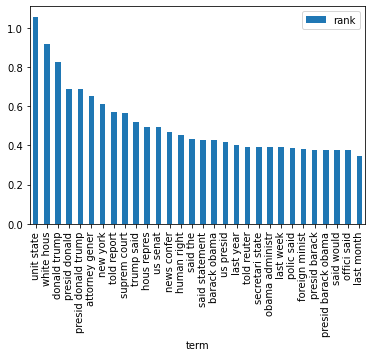

In [12]:
plot_ngrams(sample_true, 2, 3, 30) # True news

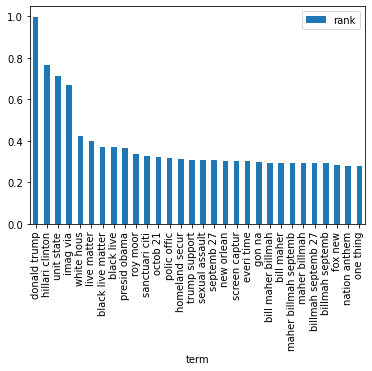

In [13]:
plot_ngrams(sample_fake, 2, 3, 30) # Fake news

We are still poisoned with the _ad hominem_ problem after seeing so many names ranking so high. However we can start to see the difference between true and fake news. True news highest ranking ngrams are just factual statements, while in the fake news the "asham" stem (probably from "ashaming" or "ashamed") and other more _emotional_ words and phrases appear. This is probably right, since a more emotional wording is usually a sign of fake news.

### Training models

The authors continue from this point with a wide analysis of several models. We can follow the same approach and do a grid search of the ngram range and the amount of features to include in the tfidf function. Also, for each trained model we'll use 5-fold cross validation and use the mean accuracy as a metric for model selection.

We're going to test the following classifiers:

- PassiveAggressiveClassifier
- SGDClassifier
- LinearSVC
- LinearRegression
- KNeighborsClassifier

Ideally I'd add a support vector machine and a random forest classifier, but I don't have enough computing power at my disposal to run this whole grid search in a reasonable amount of time. 

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

pipes = {"PassiveAggressiveClassifier": Pipeline([("tfidf", TfidfVectorizer()), ("model", PassiveAggressiveClassifier())])}
pipes["SGDClassifier"] =  Pipeline([("tfidf", TfidfVectorizer()), ("model", SGDClassifier())])
pipes["LinearSVC"] =  Pipeline([("tfidf", TfidfVectorizer()), ("model", LinearSVC())])
pipes["LinearRegression"] =  Pipeline([("tfidf", TfidfVectorizer()), ("model", LinearRegression())])
pipes["KNeighborsClassifier"] =  Pipeline([("tfidf", TfidfVectorizer()), ("model", KNeighborsClassifier())])

# Not enough computing power for these two :(
# pipes["SVC"] =  Pipeline([("tfidf", TfidfVectorizer()), ("model", SVC())])
# pipes["RandomForestClassifier"] =  Pipeline([("tfidf", TfidfVectorizer()), ("model", RandomForestClassifier())])

In [15]:
# We're testing 4 different feature sizes.
# Also we'll consider 1-grams, 2-grams 3-grams and 1- to 3- grams.
# Also, we'll see the difference between using TF or IDF

params = {
    "tfidf__max_features": (1000,5000, 10000, 50000),
    "tfidf__ngram_range": ((1,1), (2,2), (3,3), (1,3)),
    "tfidf__use_idf": (False, True)
}

In [16]:
# Let's do the grid search. We'll score results with accuracy and F1 score. This will be a long one...

results = []
for key, value in pipes.items():
    name = key
    pipe = value
    print("Fitting: {}".format(name))
    grid_search = GridSearchCV(pipe, params, n_jobs=3, verbose=4, scoring=["accuracy", "f1"], refit=False)
    grid_search.fit(preprocessed["text"], preprocessed["label"])
    result = pd.DataFrame.from_dict(grid_search.cv_results_)
    result["Classifier"] = name
    results.append(result)


Fitting: PassiveAggressiveClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting: SGDClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting: LinearSVC
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting: LinearRegression
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting: KNeighborsClassifier
Fitting 5 folds for each of 32 candidates, totalling 160 fits


Now let's check our results:

In [18]:
results_total = results[0].append(results[1:]).sort_values(by="mean_test_accuracy", ascending=False).reset_index().head(10)
results_total[["Classifier", "mean_test_accuracy", "std_test_accuracy", "mean_test_f1", "std_test_f1", "param_tfidf__max_features", "param_tfidf__ngram_range", "param_tfidf__use_idf"]]

,Classifier,mean_test_accuracy,std_test_accuracy,mean_test_f1,std_test_f1,param_tfidf__max_features,param_tfidf__ngram_range,param_tfidf__use_idf
0,PassiveAggressiveClassifier,0.980460,0.007503,0.980692,0.007275,50000,"(1, 3)",True
1,LinearSVC,0.979829,0.007228,0.980083,0.007005,50000,"(1, 3)",True
2,PassiveAggressiveClassifier,0.979246,0.007240,0.979481,0.007028,50000,"(1, 3)",False
3,LinearSVC,0.978615,0.006421,0.978843,0.006226,50000,"(1, 3)",False
4,LinearSVC,0.977004,0.006473,0.977243,0.006265,10000,"(1, 3)",False
5,LinearSVC,0.976771,0.008660,0.977101,0.008385,10000,"(1, 3)",True
6,LinearSVC,0.976234,0.006685,0.976470,0.006484,5000,"(1, 3)",False
7,PassiveAggressiveClassifier,0.976001,0.009030,0.976352,0.008741,10000,"(1, 3)",True
8,PassiveAggressiveClassifier,0.975931,0.008259,0.976278,0.007989,10000,"(1, 3)",False
9,LinearSVC,0.975837,0.008005,0.976132,0.007749,50000,"(1, 1)",True


In this case we'll focus on the Accuracy score, as arguaibly false positives/negatives are not that important. If they were, the F1 score would be the better one. As we can see the Passive Agressive Classifier had the best performance with a reasonably low standard deviation between the 5 folds. As expected the max number of features (50k) had the best performance, as well as using IDF. Also, interestingly, the dynamic range of n-grams, which wasn't used in the research paper (from 1 to 3 words per ngram) had the best performance too. This made the model more dynamic and able to get meaning when it mattered while retaining the ability of using single words.

Now we can finish by training this model on its own:

In [20]:
from sklearn.metrics import f1_score

x_train,x_test,y_train,y_test=train_test_split(preprocessed.text, preprocessed.label, test_size=0.2, random_state=123)

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features = 50000, use_idf = True)
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train,y_train)
y_pred = pac.predict(tfidf_test)
acc_score = accuracy_score(y_test,y_pred)
f1_score = f1_score(y_test,y_pred)
print("Accuracy: {:.2f} %".format(100*acc_score))
print("F1 score: {:.2f} %".format(100*f1_score))
print("Confusion Matrix:\n{}".format(confusion_matrix(y_test, y_pred)))

Accuracy: 98.84 %
F1 score: 98.87 %
Confusion Matrix:
[[4149   46]
 [  53 4319]]


Which is slightly better than what we saw in the grid search, probably due to the lack of cross validation. This result is very close to the initial naive approach, but way, way more generalizable and ready for the real world. It is also better than the paper's best result! (~90%)

We could improve this with a proper vocabulary to remove media names, VIPs, places and so on, to fully prevent ad hominem biases, and just don't use the trimming function. An overall better approach could be designed with LSTM neural networks to focus more prominently on meaning. In this approach the closest thing to meaning that we have are stemmed ngrams.

A way harder, but better, approach would be to build a full fact checker machine that somehow is able to extract topics and facts from the text with high level of detail and then scrap google to fact check these facts.

Thank you for reading all of this!